<a href="https://colab.research.google.com/github/jamalla/session_based_prefix_target_project/blob/main/notebooks/session_based_prefix_target_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0) Setup - Before you start (make sure to create the venv and the requirment.txt file ahead)

In [2]:
# Core deps for this notebook
import os, json, psutil, pandas as pd, numpy as np

print(f"Available RAM: {psutil.virtual_memory().available/2**30:.2f} GB")


Available RAM: 51.20 GB


### 0) Setup - run the following code in case you are working inside the Google Colab to bring the data from Kaggle

In [3]:
!pip -q install kaggle pyarrow fastparquet
from google.colab import files

# 1. Upload kaggle.json (from Kaggle > Settings > Create New Token)
uploaded = files.upload()  # select kaggle.json

# 2. Move into place with proper permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3. Download & unzip the YOOCHOOSE / RecSys 2015 dataset
!kaggle datasets download -d chadgostopp/recsys-challenge-2015
!unzip -q recsys-challenge-2015.zip -d data
!ls -lh data | sed -n '1,10p'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.6 MB/s eta 0:00:00


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/chadgostopp/recsys-challenge-2015
License(s): unknown
 99% 831M/841M [00:00<00:00, 1.19GB/s]
100% 841M/841M [00:00<00:00, 1.36GB/s]
total 1.8G
-rw-r--r-- 1 root root 3.9K Oct  6  2019 dataset-README.txt
-rw-r--r-- 1 root root  54M Oct  6  2019 yoochoose-buys.dat
-rw-r--r-- 1 root root 1.4G Oct  6  2019 yoochoose-clicks.dat
drwxr-xr-x 2 root root 4.0K Dec  1 04:48 yoochoose-data
-rw-r--r-- 1 root root 355M Oct  6  2019 yoochoose-test.dat


### 1) Load + Quick EDA

/tmp/ipython-input-1140267692.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  clicks = pd.read_csv(


Rows: 33003944


,session_id,timestamp,item_id,category
0,1,2014-04-07T10:51:09.277Z,214536502,0
1,1,2014-04-07T10:54:09.868Z,214536500,0
2,1,2014-04-07T10:54:46.998Z,214536506,0
3,1,2014-04-07T10:57:00.306Z,214577561,0
4,2,2014-04-07T13:56:37.614Z,214662742,0



# unique sessions: 9249729
# unique items: 52739
avg events/session: 3.568098481587947


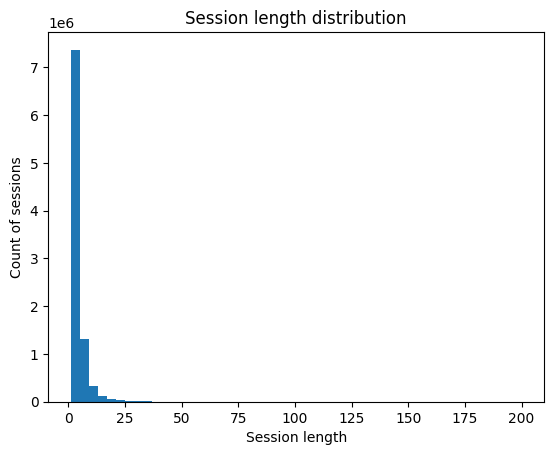


Top category values (normalized):


,proportion
category,
0,0.440826
S,0.326313
0,0.054195
1,0.050653
2,0.039154


In [6]:
# Read clicks; columns: session_id, timestamp, item_id, category
clicks = pd.read_csv(
    "data/yoochoose-clicks.dat",
    names=["session_id", "timestamp", "item_id", "category"],
)

print("Rows:", len(clicks))
display(clicks.head())

# Parse timestamp once
clicks["timestamp"] = pd.to_datetime(clicks["timestamp"])

# Basic stats
print("\n# unique sessions:", clicks["session_id"].nunique())
print("# unique items:", clicks["item_id"].nunique())
print("avg events/session:", clicks.groupby("session_id").size().mean())

# Optional: distribution of session lengths
import matplotlib.pyplot as plt
session_lengths = clicks.groupby("session_id").size()
plt.hist(session_lengths, bins=50)
plt.xlabel("Session length"); plt.ylabel("Count of sessions"); plt.title("Session length distribution")
plt.show()

# Category is mostly 0.0 (anonymized); safe to ignore in v1
print("\nTop category values (normalized):")
display(clicks["category"].value_counts(normalize=True).head(5))


### 2) Global sort + temporal split (80/10/10 by session end time)

In [ ]:
# Sort once globally so we never sort per-session again
clicks = clicks.sort_values(["session_id", "timestamp"], kind="mergesort").reset_index(drop=True)

# Session end time (max timestamp per session), then temporal split
session_end = clicks.groupby("session_id")["timestamp"].max().sort_values()
n_sess = len(session_end)
cut80, cut90 = int(n_sess*0.8), int(n_sess*0.9)

train_sessions = session_end.index[:cut80]
valid_sessions = session_end.index[cut80:cut90]
test_sessions  = session_end.index[cut90:]

def filter_sessions(df, session_ids):
    return df[df.session_id.isin(session_ids)].copy()

train_df = filter_sessions(clicks, train_sessions)
valid_df = filter_sessions(clicks, valid_sessions)
test_df  = filter_sessions(clicks, test_sessions)

print("Split rows:", len(train_df), len(valid_df), len(test_df))


Split rows: 26695045 3120271 3188628


### 3) Train-only item filter + drop short sessions + remap ids

In [ ]:
# Train-only frequency filter (keeps evaluation realistic)
item_counts = train_df["item_id"].value_counts()
valid_items = item_counts[item_counts >= 5].index

train_df = train_df[train_df.item_id.isin(valid_items)]
valid_df = valid_df[valid_df.item_id.isin(valid_items)]
test_df  = test_df[test_df.item_id.isin(valid_items)]

# Drop sessions shorter than 2 events (can’t form prefix->target)
def drop_short_sessions(df):
    lengths = df.groupby("session_id").size()
    keep_ids = lengths[lengths >= 2].index
    return df[df.session_id.isin(keep_ids)]

train_df = drop_short_sessions(train_df)
valid_df = drop_short_sessions(valid_df)
test_df  = drop_short_sessions(test_df)

# Remap item IDs to contiguous [1..N] (0 reserved for padding later)
item2idx = {item: idx+1 for idx, item in enumerate(valid_items)}
train_df["item_id"] = train_df["item_id"].map(item2idx)
valid_df["item_id"] = valid_df["item_id"].map(item2idx)
test_df["item_id"]  = test_df["item_id"].map(item2idx)

print("Unique items after filtering:", len(item2idx))


Unique items after filtering: 34824


### 4) Optional: cap very long sessions (keeps size/variance in check)

In [ ]:
def cap_session_length(df, k=50):
    # keep earliest k events per session
    return (df.groupby("session_id", group_keys=False)
              .apply(lambda g: g.nsmallest(k, "timestamp")))

# Uncomment to cap to 50 events; recommended for faster runs
# train_df = cap_session_length(train_df, 50)
# valid_df = cap_session_length(valid_df, 50)
# test_df  = cap_session_length(test_df, 50)


### 5) Fast prefix→target pair generation (streamed to Parquet)

In [ ]:
import pyarrow as pa, pyarrow.parquet as pq

def make_pairs_fast(df, min_prefix_len=1, max_prefix_len=50):
    """
    Assumes df is sorted by ['session_id','timestamp'].
    Yields (prefix:list[int], target:int) with minimal copying.
    """
    items = df["item_id"].to_numpy()
    sess  = df["session_id"].to_numpy()

    n, i = len(df), 0
    while i < n:
        j = i + 1
        while j < n and sess[j] == sess[i]:
            j += 1
        seq = items[i:j]
        L = len(seq)
        if L >= min_prefix_len + 1:
            end = min(L - 1, max_prefix_len if max_prefix_len is not None else (L - 1))
            for k in range(min_prefix_len, end + 1):
                yield (seq[:k].tolist(), int(seq[k]))
        i = j

def write_pairs_parquet(pair_iter, out_path, chunk_size=200_000, compression="snappy"):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    writer, bufP, bufT = None, [], []
    for p, t in pair_iter:
        bufP.append(p); bufT.append(t)
        if len(bufP) >= chunk_size:
            tbl = pa.Table.from_pydict({"prefix": bufP, "target": bufT})
            if writer is None:
                writer = pq.ParquetWriter(out_path, tbl.schema, compression=compression)
            writer.write_table(tbl); bufP, bufT = [], []
    if bufP:
        tbl = pa.Table.from_pydict({"prefix": bufP, "target": bufT})
        if writer is None:
            writer = pq.ParquetWriter(out_path, tbl.schema, compression=compression)
        writer.write_table(tbl)
    if writer: writer.close()

# Generate and write
os.makedirs("data/processed", exist_ok=True)
write_pairs_parquet(make_pairs_fast(train_df, min_prefix_len=1, max_prefix_len=50),
                    "data/processed/train_pairs.parquet")
write_pairs_parquet(make_pairs_fast(valid_df, min_prefix_len=1, max_prefix_len=50),
                    "data/processed/valid_pairs.parquet")
write_pairs_parquet(make_pairs_fast(test_df,  min_prefix_len=1, max_prefix_len=50),
                    "data/processed/test_pairs.parquet")

# Save item map
with open("data/processed/item_map.json", "w") as f:
    json.dump(item2idx, f)


### 6) Validation pack (quick sanity checks)

In [ ]:
train_pq = pd.read_parquet("data/processed/train_pairs.parquet")
valid_pq = pd.read_parquet("data/processed/valid_pairs.parquet")
test_pq  = pd.read_parquet("data/processed/test_pairs.parquet")

print("Pairs per split:", len(train_pq), len(valid_pq), len(test_pq))
display(train_pq.head(3))

def pref_len(s): return s.apply(len)
for name, df in [("train", train_pq), ("valid", valid_pq), ("test", test_pq)]:
    L = pref_len(df["prefix"])
    print(f"[{name}] avg_prefix={L.mean():.2f} | median={L.median():.0f} | min={L.min()} | max={L.max()}")

# Hard checks
with open("data/processed/item_map.json") as f:
    item2idx = json.load(f)
N = len(item2idx)

assert train_pq["prefix"].map(len).min() >= 1
assert train_pq["prefix"].map(lambda x: all(1 <= v <= N for v in x)).all()
assert train_pq["target"].between(1, N).all()
print("Basic validations passed.")


Pairs per split: 19194232 1787284 1200751


,prefix,target
0,[2976],6976
1,"[2976, 6976]",17872
2,"[2976, 6976, 17872]",14607


[train] avg_prefix=4.25 | median=2 | min=1 | max=50
[valid] avg_prefix=4.08 | median=2 | min=1 | max=50
[test] avg_prefix=4.06 | median=2 | min=1 | max=50
Basic validations passed.


### 7) Inspect a real session (build intuition)

In [ ]:
# Pick a real session and see its items over time
some_sid = int(train_df["session_id"].iloc[0])
session_df = train_df[train_df["session_id"] == some_sid].sort_values("timestamp")
print(f"Session {some_sid} — {len(session_df)} events")
display(session_df[["session_id","timestamp","item_id"]].head(10))


Session 1 — 4 events


,session_id,timestamp,item_id
0,1,2014-04-07 10:51:09.277000+00:00,2976
1,1,2014-04-07 10:54:09.868000+00:00,6976
2,1,2014-04-07 10:54:46.998000+00:00,17872
3,1,2014-04-07 10:57:00.306000+00:00,14607


### 8) Step-by-step: timeline visualization

In [ ]:
# STEP 1 — install dependencies (if not already)
!pip -q install plotly pandas matplotlib

import pandas as pd
import plotly.express as px


In [ ]:
# STEP 2 — sample a small subset of sessions to visualize
# (full dataset is huge; plotting too many sessions will freeze the browser)

# choose, for example, 20 random sessions from train_df
sample_sessions = train_df["session_id"].drop_duplicates().sample(20, random_state=42)
sample_df = train_df[train_df["session_id"].isin(sample_sessions)].copy()

# ensure chronological order
sample_df = sample_df.sort_values(["session_id", "timestamp"])


In [ ]:
# STEP 3 — compute a time offset for each session to normalize start times
# so you can see relative timing inside each session

sample_df["session_start"] = sample_df.groupby("session_id")["timestamp"].transform("min")
sample_df["relative_time_sec"] = (sample_df["timestamp"] - sample_df["session_start"]).dt.total_seconds()


In [ ]:
# STEP 4 — create the timeline chart (horizontal bars per session)

fig = px.scatter(
    sample_df,
    x="relative_time_sec",
    y="session_id",
    color="item_id",
    hover_data=["timestamp", "item_id"],
    title="Session timelines (each dot = clicked item)",
    labels={
        "relative_time_sec": "Seconds since session start",
        "session_id": "Session ID",
        "item_id": "Item (colored)"
    },
    height=600
)

fig.update_traces(marker=dict(size=10, line=dict(width=0)))
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()


In [ ]:
fig = px.line(
    sample_df,
    x="relative_time_sec",
    y="session_id",
    color="session_id",
    markers=True,
    title="Session timelines (sequence lines)"
)
fig.update_traces(line=dict(width=2))
fig.show()


In [ ]:
import plotly.graph_objects as go

# copy and compute relative times again to ensure consistency
sample_df = train_df[train_df["session_id"].isin(sample_sessions)].copy()
sample_df = sample_df.sort_values(["session_id", "timestamp"])
sample_df["session_start"] = sample_df.groupby("session_id")["timestamp"].transform("min")
sample_df["relative_time_sec"] = (sample_df["timestamp"] - sample_df["session_start"]).dt.total_seconds()

# mark last item per session as 'target'
sample_df["is_target"] = sample_df.groupby("session_id")["timestamp"].transform("max") == sample_df["timestamp"]

# split into prefix and target points
prefix_df = sample_df[~sample_df["is_target"]]
target_df = sample_df[sample_df["is_target"]]


### 9) draw the timeline with prefixes + targets

In [ ]:
fig = go.Figure()

# add session sequences (prefix clicks)
for sid, grp in prefix_df.groupby("session_id"):
    fig.add_trace(go.Scatter(
        x=grp["relative_time_sec"],
        y=[sid]*len(grp),
        mode="lines+markers",
        name=f"Session {sid}",
        marker=dict(size=6),
        line=dict(width=1),
        hovertext=[f"item {i}" for i in grp["item_id"]],
        hoverinfo="text"
    ))

# overlay red dots for target items
fig.add_trace(go.Scatter(
    x=target_df["relative_time_sec"],
    y=target_df["session_id"],
    mode="markers",
    name="Target (last item)",
    marker=dict(size=12, color="red", symbol="x"),
    hovertext=[f"target {i}" for i in target_df["item_id"]],
    hoverinfo="text"
))

fig.update_layout(
    title="Session Timelines with Target Highlighted",
    xaxis_title="Seconds since session start",
    yaxis_title="Session ID",
    height=600,
    showlegend=True
)
fig.show()


In [ ]:
# Add a text box inside the chart explaining the labels
fig.add_annotation(
    text=(
        "<b>Legend:</b><br>"
        "• <b>Colored Line</b> – Session journey (sequence of clicks)<br>"
        "• <b>Dots</b> – Items clicked during the session (prefix)<br>"
        "• <b>Red ×</b> – Last clicked item (target)<br>"
        "• <b>X-axis</b> – Time since session started (in seconds)<br>"
        "• <b>Y-axis</b> – Session ID (each line = one session)"
    ),
    align="left",
    showarrow=False,
    bordercolor="gray",
    borderwidth=1,
    borderpad=10,
    bgcolor="rgba(255,255,255,0.8)",
    font=dict(size=12),
    xref="paper",
    yref="paper",
    x=1.05,     # position to the right of the chart
    y=1,        # top alignment
)

fig.update_layout(
    title="Session Timelines with Target Highlighted",
    xaxis_title="Seconds since session start",
    yaxis_title="Session ID",
    height=650,
    showlegend=False  # hide the default legend to reduce clutter
)

fig.show()


### 10) Update the Chart to Use Normalized Sessions IDs

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# 1) Build sample_df (make sure this matches your earlier sampling)
sample_sessions = train_df["session_id"].drop_duplicates().sample(20, random_state=42)
sample_df = train_df[train_df["session_id"].isin(sample_sessions)].copy()
sample_df = sample_df.sort_values(["session_id","timestamp"])
sample_df["session_start"] = sample_df.groupby("session_id")["timestamp"].transform("min")
sample_df["relative_time_sec"] = (sample_df["timestamp"] - sample_df["session_start"]).dt.total_seconds()

# 2) Add normalized IDs BEFORE splitting
# factorize is simple and robust: gives 1..N labels in the order they appear
sample_df["session_idx"] = pd.factorize(sample_df["session_id"])[0] + 1

# 3) Mark targets and split
sample_df["is_target"] = (
    sample_df.groupby("session_id")["timestamp"].transform("max") == sample_df["timestamp"]
)
prefix_df = sample_df[~sample_df["is_target"]].copy()
target_df = sample_df[sample_df["is_target"]].copy()

# 4) Plot
fig = go.Figure()

for sid, grp in prefix_df.groupby("session_idx"):
    fig.add_trace(go.Scatter(
        x=grp["relative_time_sec"],
        y=[sid]*len(grp),
        mode="lines+markers",
        name=f"Session {sid}",
        marker=dict(size=6),
        line=dict(width=1),
        hovertext=[f"item {i}" for i in grp["item_id"]],
        hoverinfo="text"
    ))

fig.add_trace(go.Scatter(
    x=target_df["relative_time_sec"],
    y=target_df["session_idx"],
    mode="markers",
    name="Target (last item)",
    marker=dict(size=12, color="red", symbol="x"),
    hovertext=[f"target {i}" for i in target_df["item_id"]],
    hoverinfo="text"
))

fig.add_annotation(
    text=(
        "<b>Legend:</b><br>"
        "• <b>Colored Line</b> – Session journey (sequence of clicks)<br>"
        "• <b>Dots</b> – Items clicked (prefix)<br>"
        "• <b>Red ×</b> – Last clicked item (target)<br>"
        "• <b>X-axis</b> – Seconds since session start<br>"
        "• <b>Y-axis</b> – Normalized session index"
    ),
    align="left", showarrow=False, bordercolor="gray", borderwidth=1, borderpad=10,
    bgcolor="rgba(255,255,255,0.85)", font=dict(size=12), xref="paper", yref="paper", x=1.05, y=1
)

fig.update_layout(
    title="Session Timelines (Normalized IDs) with Target Highlighted",
    xaxis_title="Seconds since session start",
    yaxis_title="Normalized Session Index",
    height=650, showlegend=False
)
fig.show()


In [ ]:
fig.update_layout(
    title="Session Timelines (Normalized IDs) with Target Highlighted",
    xaxis_title="Seconds since session start",
    yaxis_title="Normalized Session Index",
    height=650,
    showlegend=False
)


### 11) Summary of Train / Validation / Test Splits

#### 1. Purpose of the Split
The dataset is divided into **Train (80%)**, **Validation (10%)**, and **Test (10%)**
to mimic real-world time progression — ensuring that the model learns from past sessions
and is evaluated on future ones.

---

#### 2. How the Split Works
- Each `session_id` is treated as a single unit (sessions are not mixed).
- Compute each session’s **end timestamp**.
- Sort sessions chronologically by end time.
- Assign:
  - Earliest 80% → **Train**
  - Next 10% → **Validation**
  - Final 10% → **Test**

---

#### 3. Why Temporal Splitting (Not Random)
Temporal splits prevent **data leakage**, where future user behavior accidentally influences training.  
In session-based recommendations, the goal is to predict the next action using only **past** data.

---

#### 4. Validation Steps
- **No overlap:** Ensure no `session_id` appears in more than one split.  
- **Chronological order:** Verify timestamps in the test set occur after those in train/validation.  
- **Balanced stats:** Confirm that average session lengths and item counts are similar across splits.

---

#### 5. Quick Validation Checks (Python Example)

In [ ]:
def session_summary(df, name):
    """Print basic info about one dataset split."""
    n_rows = len(df)
    n_sessions = df["session_id"].nunique()
    n_items = df["item_id"].nunique()
    avg_len = df.groupby("session_id").size().mean()
    print(f"--- {name.upper()} ---")
    print(f"Rows: {n_rows:,}")
    print(f"Sessions: {n_sessions:,}")
    print(f"Unique items: {n_items:,}")
    print(f"Avg. events/session: {avg_len:.2f}")
    print("-" * 40)

# Display summaries
session_summary(train_df, "train")
session_summary(valid_df, "validate")
session_summary(test_df, "test")


--- TRAIN ---
Rows: 25,810,925
Sessions: 6,540,935
Unique items: 34,821
Avg. events/session: 3.95
----------------------------------------
--- VALIDATE ---
Rows: 2,425,953
Sessions: 631,893
Unique items: 23,065
Avg. events/session: 3.84
----------------------------------------
--- TEST ---
Rows: 1,647,390
Sessions: 442,488
Unique items: 22,446
Avg. events/session: 3.72
----------------------------------------


In [ ]:
print("\nSample rows from TRAIN:")
display(train_df.head(5)[["session_id","timestamp","item_id"]])

print("\nSample rows from VALIDATE:")
display(valid_df.head(5)[["session_id","timestamp","item_id"]])

print("\nSample rows from TEST:")
display(test_df.head(5)[["session_id","timestamp","item_id"]])



Sample rows from TRAIN:


,session_id,timestamp,item_id
0,1,2014-04-07 10:51:09.277000+00:00,2976
1,1,2014-04-07 10:54:09.868000+00:00,6976
2,1,2014-04-07 10:54:46.998000+00:00,17872
3,1,2014-04-07 10:57:00.306000+00:00,14607
4,2,2014-04-07 13:56:37.614000+00:00,2568



Sample rows from VALIDATE:


,session_id,timestamp,item_id
26566438,9194109,2014-08-30 12:17:10.446000+00:00,8792
26566439,9194109,2014-08-30 12:18:11.869000+00:00,210
26566440,9194111,2014-08-31 17:40:46.805000+00:00,602
26566441,9194111,2014-08-31 17:42:26.089000+00:00,3608
26566442,9194111,2014-08-31 17:44:06.583000+00:00,2



Sample rows from TEST:


,session_id,timestamp,item_id
29357395,10230517,2014-09-15 17:34:51.865000+00:00,886
29357396,10230517,2014-09-15 17:34:55.669000+00:00,886
29357405,10230523,2014-09-13 09:53:48.076000+00:00,185
29357406,10230523,2014-09-13 10:26:45.896000+00:00,199
29357407,10230524,2014-09-12 12:48:54.577000+00:00,1398


In [ ]:
train_max = train_df["timestamp"].max()
valid_min = valid_df["timestamp"].min()

print("Train max timestamp:", train_max)
print("Valid min timestamp:", valid_min)

# Find sessions that ended exactly at the train boundary
overlap_sessions = train_df.loc[train_df["timestamp"] == train_max, "session_id"].unique()
print(f"\nSessions ending exactly at boundary: {len(overlap_sessions)}")


Train max timestamp: 2014-08-27 11:32:53.428000+00:00
Valid min timestamp: 2014-08-27 05:21:23.339000+00:00

Sessions ending exactly at boundary: 1


In [ ]:
# --- Robust temporal split by session END time (handles ties) ---

# 1) Compute end time per session
sess_end = (clicks.groupby("session_id")["timestamp"]
            .max()
            .sort_values(kind="mergesort"))  # stable order

n = len(sess_end)
cut80, cut90 = int(n*0.8), int(n*0.9)

# 2) Choose cut thresholds by rank
t1 = sess_end.iloc[cut80-1]  # train upper bound (inclusive for ties)
t2 = sess_end.iloc[cut90-1]  # valid upper bound (inclusive for ties)

# 3) Assign by end-time with explicit tie handling:
#    - Train: end < t1
#    - Valid: t1 <= end < t2
#    - Test:  end >= t2
train_sids = sess_end.index[sess_end <  t1]
valid_sids = sess_end.index[(sess_end >= t1) & (sess_end <  t2)]
test_sids  = sess_end.index[sess_end >= t2]

# 4) Build splits
train_df = clicks[clicks.session_id.isin(train_sids)].copy()
valid_df = clicks[clicks.session_id.isin(valid_sids)].copy()
test_df  = clicks[clicks.session_id.isin(test_sids)].copy()

# --- Validation: check on SESSION END times (not raw events) ---
train_end_max = sess_end.loc[train_sids].max()
valid_end_min = sess_end.loc[valid_sids].min()
valid_end_max = sess_end.loc[valid_sids].max()
test_end_min  = sess_end.loc[test_sids].min()

print("train_end_max:", train_end_max)
print("valid_end_min:", valid_end_min)
print("valid_end_max:", valid_end_max)
print("test_end_min :", test_end_min)

# These should hold:
assert train_end_max <  valid_end_min or pd.isna(train_end_max)
assert valid_end_max <= test_end_min   or pd.isna(valid_end_max)

# Also ensure no session overlaps:
assert set(train_sids).isdisjoint(valid_sids)
assert set(train_sids).isdisjoint(test_sids)
assert set(valid_sids).isdisjoint(test_sids)

print("✅ Temporal split is clean (by session end time).")


train_end_max: 2014-08-27 11:32:53.430000+00:00
valid_end_min: 2014-08-27 11:32:54.765000+00:00
valid_end_max: 2014-09-12 10:48:03.729000+00:00
test_end_min : 2014-09-12 10:48:06.795000+00:00
✅ Temporal split is clean (by session end time).


### 12) Baseline Modeling & Evaluation

#### Session-based k-Nearest Neighbors (Session-KNN)

Load valid_pairs.parquet (or test_pairs.parquet), generate predictions, and feed them with the true target column into evaluate_topk.

we can directly load and evaluate YooChoose dataset using the metrics we built (HitRate@K and MRR@K).

We’ll start with two quick baselines:

Popularity (POP) — recommends the globally most frequent items in training data.

Session-KNN — (we’ll add this after) recommends based on similarity between sessions.

For now, let’s implement the Popularity baseline, using your real processed dataset.

In [ ]:
import numpy as np
from typing import List, Sequence, Dict

# ---------- Metrics definitions ----------
def _ensure_2d(preds: Sequence[Sequence[int]]) -> List[List[int]]:
    return [list(p) for p in preds]

def hitrate_at_k(preds: Sequence[Sequence[int]], targets: Sequence[int], k: int) -> float:
    preds = _ensure_2d(preds)
    targets = np.asarray(targets)
    assert len(preds) == len(targets)
    hits = [1.0 if t in p[:k] else 0.0 for p, t in zip(preds, targets)]
    return float(np.mean(hits)) if hits else 0.0

def mrr_at_k(preds: Sequence[Sequence[int]], targets: Sequence[int], k: int) -> float:
    preds = _ensure_2d(preds)
    targets = np.asarray(targets)
    assert len(preds) == len(targets)
    rr = []
    for p, t in zip(preds, targets):
        topk = p[:k]
        try:
            rank = topk.index(t) + 1
            rr.append(1.0 / rank)
        except ValueError:
            rr.append(0.0)
    return float(np.mean(rr)) if rr else 0.0

def evaluate_topk(preds: Sequence[Sequence[int]], targets: Sequence[int], ks: Sequence[int] = (5, 10, 20)) -> Dict[str, float]:
    preds = _ensure_2d(preds)
    targets = np.asarray(targets)
    out = {}
    for k in ks:
        out[f"Hit@{k}"] = hitrate_at_k(preds, targets, k)
        out[f"MRR@{k}"] = mrr_at_k(preds, targets, k)
    return out

print("✅ Metrics functions loaded successfully (HitRate@K & MRR@K).")


✅ Metrics functions loaded successfully (HitRate@K & MRR@K).


In [ ]:
# import pandas as pd
# import numpy as np
from collections import Counter

# === Load processed data ===
train_pairs = pd.read_parquet("data/processed/train_pairs.parquet")
valid_pairs = pd.read_parquet("data/processed/valid_pairs.parquet")
test_pairs  = pd.read_parquet("data/processed/test_pairs.parquet")

print("Loaded:")
print(f"Train pairs: {len(train_pairs):,}")
print(f"Valid pairs: {len(valid_pairs):,}")
print(f"Test pairs : {len(test_pairs):,}")

# === Build a simple popularity model ===
# Count item frequencies across all targets in training data
item_popularity = Counter(train_pairs["target"])
popular_items = [item for item, _ in item_popularity.most_common()]

# === Predict: for every example, return the same top-N items ===
def predict_popularity(n_preds, top_items):
    return [top_items for _ in range(n_preds)]

# === Evaluate on validation set ===
from math import isnan

valid_preds = predict_popularity(len(valid_pairs), popular_items)
valid_targets = valid_pairs["target"].tolist()

metrics_valid = evaluate_topk(valid_preds, valid_targets, ks=[5, 10, 20])
print("\n Popularity Baseline — Validation Results")
for k, v in metrics_valid.items():
    print(f"{k}: {v:.4f}")

# === Evaluate on test set ===
test_preds = predict_popularity(len(test_pairs), popular_items)
test_targets = test_pairs["target"].tolist()

metrics_test = evaluate_topk(test_preds, test_targets, ks=[5, 10, 20])
print("\n Popularity Baseline — Test Results")
for k, v in metrics_test.items():
    print(f"{k}: {v:.4f}")


Loaded:
Train pairs: 19,194,232
Valid pairs: 1,787,284
Test pairs : 1,200,751


Chart: Distribution of Prefix Lengths

In [ ]:
import matplotlib.pyplot as plt

def plot_prefix_length_distribution(df, name):
    df["prefix_len"] = df["prefix"].apply(len)
    plt.figure(figsize=(6,4))
    plt.hist(df["prefix_len"], bins=50, color="steelblue", alpha=0.7)
    plt.title(f"Prefix Length Distribution — {name}")
    plt.xlabel("Prefix length (# of previous clicks)")
    plt.ylabel("Count")
    plt.show()

plot_prefix_length_distribution(train_pairs, "Train")
plot_prefix_length_distribution(valid_pairs, "Validation")
plot_prefix_length_distribution(test_pairs, "Test")
